In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

# Importing necessary libraries above

# Hypothesis-> We choose XRP as our crypto asset, Then as to check if our other assets have predicting power over XRP.

#The other assets are ->NASDAQ composite, CMC 200 crypto (volatility index of crypto currency), EEM (An emerging market ETF) and the Dollar index against 6 other currencies.



#XRP -> It is used Design and facilitate fast, cheap cross-border transactions.

# The reason why I chose these assets is because, IXIC is an indicator of the technology sector,A thriving technology sector could potentially increase demand for solutions like XRP, cryptocurrency. To see how tech sector influences crypto market investment as they are tied closed to each other.

#CMC200 crypto-> It is an Overall Crypto Market Performance/ volatility index of the crypto market, Overall Crypto Market Performance.

#DXY-> It is the US Dollar Strength & Currency Exchange for USD against 6 countries, A weaker US dollar (falling DXY) might benefit XRP price (denominated in USD).

#EEM-> Tracks a basket of stocks from emerging markets (excluding China), It is data about emerging markets, I chose this asset to see the Risk Appetite & Investor Sentiment, because a Risk-on environment with a rising EEM could potentially benefit XRP.  If the performance of emerging markets (reflected by EEM) is strong, it could lead to a generally more optimistic investment environment. This might encourage investors to allocate a portion of their portfolio to riskier assets like cryptocurrencies, potentially including XRP.

# Now we download the desired assets

In [2]:
tickers = ['XRP-USD', '^IXIC', 'EEM','DX-Y.NYB','^CMC200']
start_date = '2023-03-01'
end_date = '2024-04-30'

In [3]:
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Now we store them in respective dataframes

In [4]:
# Create individual data frames for each ticker
XRP_df = data['XRP-USD']
IXIC_df = data['^IXIC']
EEM_df = data['EEM']
DXY_df = data['DX-Y.NYB']
CMC200_df = data['^CMC200']


In [5]:
#Check for missing data in each data frame
print(CMC200_df.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [6]:
#Checking for the size of each dataframe.
XRP_df.shape
EEM_df.shape
DXY_df.shape
CMC200_df.shape
IXIC_df.shape


(293, 6)

In [7]:
XRP_df.shape

(426, 6)

# Now for further analysis we set the data index as a column

In [8]:
XRP_df.reset_index(inplace=True)  # Reset the index to make 'Date' a column
XRP_df.rename(columns={'Date': 'date'}, inplace=True)

# We calculate the returns for the XRP data

In [9]:
XRP_df['Returns'] = XRP_df['Close'].pct_change()

In [10]:
XRP_df.head()

,date,Open,High,Low,Close,Adj Close,Volume,Returns
0,2023-03-01,0.377133,0.384246,0.373666,0.383879,0.383879,912485438,NaN
1,2023-03-02,0.383881,0.384199,0.374483,0.377580,0.377580,812536878,-0.016409
2,2023-03-03,0.377587,0.379156,0.359894,0.377671,0.377671,1204150691,0.000241
3,2023-03-04,0.377671,0.379521,0.370274,0.373813,0.373813,556621575,-0.010215
4,2023-03-05,0.373819,0.377127,0.366796,0.367194,0.367194,505577640,-0.017707


# Defining X and finding Target variable


In [11]:
#Calculating the average price in next 5 days
XRP_df['rolling_avg_next_5'] = XRP_df['Close'].rolling(window=5).mean().shift(-5)

# Calculating the average return in the next 5 days
XRP_df['average_return_next_5_days'] = (XRP_df['rolling_avg_next_5'] - XRP_df['Close']) / XRP_df['Close']

# Define X as 80th percentile or 90th percentile
X = XRP_df['average_return_next_5_days'].quantile(0.8)
if X < 0.02:
    X = XRP_df['average_return_next_5_days'].quantile(0.9)

In [12]:
X

0.03076420725136516

# As we can see the Target variable column will be populated by boolean, True or false, so we convert the necessary to binary 1 or 0 accordingly.

In [13]:
XRP_df['target'] = (XRP_df['average_return_next_5_days'] >= X).shift(-5).dropna()
XRP_df = XRP_df.dropna(subset=['target'])
XRP_df['target']=XRP_df['target'].astype(int)

<ipython-input-13-cf7270a628c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XRP_df['target']=XRP_df['target'].astype(int)


# Now we want to calculate the features, so we use SQL.

In [14]:
import sqlite3

conn = sqlite3.connect("crypto_data.db")
conn.execute("DROP TABLE IF EXISTS xrp_data;")
XRP_df.to_sql("xrp_data", conn, if_exists="replace",index=False)

421

# We are trying to calculate features such as Rate of change (ROC) of 3 days, CMF(Chaikin Money flow) a trend indicator based on price and volume, Cumulative returns for the past 14 days, and Bollinger band widths(BBW)

In [15]:
conn.execute("ALTER TABLE xrp_data ADD COLUMN CMF FLOAT;")
conn.execute("ALTER TABLE xrp_data ADD COLUMN ROC_3 FLOAT;")
conn.execute("ALTER TABLE xrp_data ADD COLUMN Cumulative_Return_14 FLOAT;")
conn.execute("ALTER TABLE xrp_data ADD COLUMN BBW FLOAT;")


conn.execute("""
UPDATE xrp_data
SET BBW = (
  (2 * (
          SELECT SQRT(AVG((Close - avg_close) * (Close - avg_close)))
          FROM (
              SELECT Close, AVG(Close) OVER (ORDER BY date ROWS BETWEEN 20 PRECEDING AND CURRENT ROW) AS avg_close
              FROM xrp_data AS x
              WHERE x.date <= xrp_data.date
              ORDER BY x.date DESC
              LIMIT 10
          )
      )) / (
          SELECT AVG(Close)
          FROM xrp_data AS x
          WHERE x.date <= xrp_data.date
          ORDER BY x.date DESC
          LIMIT 10
      )
) * 100;
""")

# Update ROC for a 7-day window
conn.execute("""
UPDATE xrp_data
SET ROC_3 = (
  CASE
    WHEN (SELECT COUNT(*) FROM xrp_data AS x WHERE x.date < xrp_data.date) < 3 THEN NULL
    ELSE (
      (Returns - (SELECT AVG(Returns) FROM xrp_data AS x WHERE x.date < xrp_data.date LIMIT 3)) /
      (SELECT AVG(Returns) FROM xrp_data AS x WHERE x.date < xrp_data.date LIMIT 3)
    ) * 100
  END
);
""")

# Update Cumulative Return for a 14-day window
conn.execute("""
UPDATE xrp_data SET
    Cumulative_Return_14 = (
        SELECT CASE WHEN COUNT(*) = 14 THEN SUM(Returns) ELSE NULL END
        FROM (SELECT Returns FROM xrp_data AS x WHERE x.date <= xrp_data.date ORDER BY x.date DESC LIMIT 14)
    );
""")
conn.commit()

# Update CMF window
conn.execute("""
UPDATE xrp_data
SET CMF = (
    SELECT SUM((2 * Close - High - Low) * Volume) / SUM(Volume)
    FROM (
        SELECT Close, High, Low, Volume
        FROM xrp_data AS t2
        WHERE t2.date <= xrp_data.date
        ORDER BY t2.date DESC
        LIMIT 14  -- Consider a 14-day period for CMF
    )
)
WHERE date NOT IN (
    SELECT date FROM xrp_data AS t3 WHERE t3.date = (
        SELECT MIN(date) FROM xrp_data
    )
);
""")

# Commit the changes to the database
conn.commit()


In [16]:
XRP_indicators = pd.read_sql('SELECT date, Close, CMF, ROC_3, Cumulative_Return_14, BBW FROM xrp_data ORDER BY date', conn)
print(XRP_indicators.head(30))

                   date     Close       CMF         ROC_3  \
0   2023-03-01 00:00:00  0.383879       NaN           NaN   
1   2023-03-02 00:00:00  0.377580  0.003549           NaN   
2   2023-03-03 00:00:00  0.377671  0.008788           NaN   
3   2023-03-04 00:00:00  0.373813  0.007038     26.365142   
4   2023-03-05 00:00:00  0.367194  0.004939    101.342097   
5   2023-03-06 00:00:00  0.370471  0.005337   -180.966129   
6   2023-03-07 00:00:00  0.380548  0.006143   -486.751714   
7   2023-03-08 00:00:00  0.389188  0.006013  -1810.325194   
8   2023-03-09 00:00:00  0.372130  0.001832  -2181.569793   
9   2023-03-10 00:00:00  0.370622  0.002430     11.441198   
10  2023-03-11 00:00:00  0.366832  0.001972    177.692464   
11  2023-03-12 00:00:00  0.373318  0.003475   -507.691304   
12  2023-03-13 00:00:00  0.373786  0.004015   -153.684369   
13  2023-03-14 00:00:00  0.374279  0.003097   -164.773892   
14  2023-03-15 00:00:00  0.360558  0.001631   1961.749306   
15  2023-03-16 00:00:00 

In [17]:
conn.close()

# Plotting the time series of the average returns on XRP

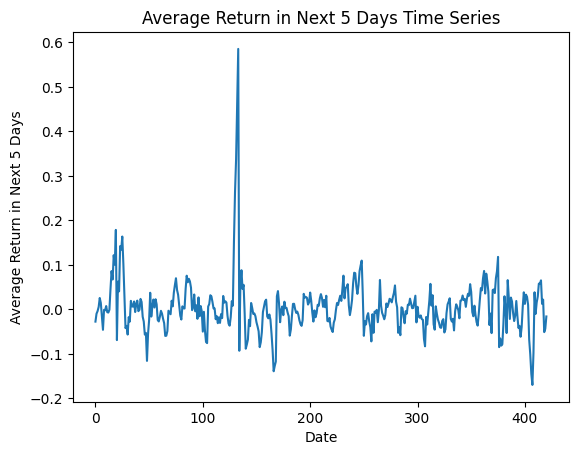

In [18]:
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline
plt.plot(XRP_df.index, XRP_df['average_return_next_5_days'])
plt.xlabel('Date')
plt.ylabel('Average Return in Next 5 Days')
plt.title('Average Return in Next 5 Days Time Series')
plt.show()

# Let's explore the Target variable to see the distribution.

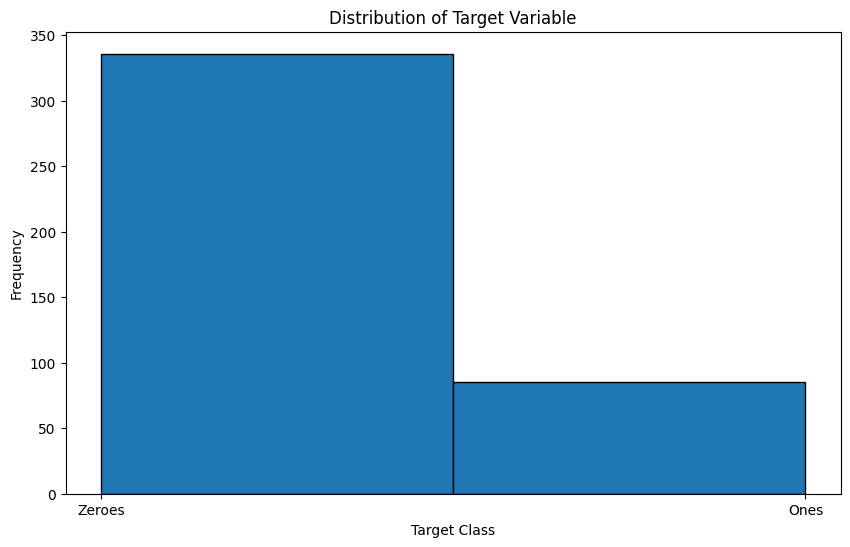

In [19]:
import matplotlib.pyplot as plt
# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
plt.hist(XRP_df['target'], bins=2, edgecolor='black')
plt.title('Distribution of Target Variable')
plt.xlabel('Target Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Zeroes', 'Ones'])
plt.show()

# Now after Calculating the respective features, lets merge them with the target variable column based on date.

In [20]:
XRP_indicators['date'] = pd.to_datetime(XRP_indicators['date'])
XRP_df['date'] = pd.to_datetime(XRP_df['date'])

# Merge the DataFrames on the 'date' column
XRP_final_df = pd.merge(XRP_indicators, XRP_df[['date', 'target']], on='date', how='inner')

# Check the merged DataFrame
print(XRP_final_df.head(15))

# Optionally, you can set 'date' as the index if needed for time series analysis
XRP_final_df.set_index('date', inplace=True)

         date     Close       CMF        ROC_3  Cumulative_Return_14  \
0  2023-03-01  0.383879       NaN          NaN                   NaN   
1  2023-03-02  0.377580  0.003549          NaN                   NaN   
2  2023-03-03  0.377671  0.008788          NaN                   NaN   
3  2023-03-04  0.373813  0.007038    26.365142                   NaN   
4  2023-03-05  0.367194  0.004939   101.342097                   NaN   
5  2023-03-06  0.370471  0.005337  -180.966129                   NaN   
6  2023-03-07  0.380548  0.006143  -486.751714                   NaN   
7  2023-03-08  0.389188  0.006013 -1810.325194                   NaN   
8  2023-03-09  0.372130  0.001832 -2181.569793                   NaN   
9  2023-03-10  0.370622  0.002430    11.441198                   NaN   
10 2023-03-11  0.366832  0.001972   177.692464                   NaN   
11 2023-03-12  0.373318  0.003475  -507.691304                   NaN   
12 2023-03-13  0.373786  0.004015  -153.684369                  

<ipython-input-20-d8214746d47c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XRP_df['date'] = pd.to_datetime(XRP_df['date'])


In [21]:
XRP_final_df.head(15)

,Close,CMF,ROC_3,Cumulative_Return_14,BBW,target
date,,,,,,
2023-03-01,0.383879,NaN,NaN,NaN,0.000000,0
2023-03-02,0.377580,0.003549,NaN,NaN,1.169880,0
2023-03-03,0.377671,0.008788,NaN,NaN,1.140962,0
2023-03-04,0.373813,0.007038,26.365142,NaN,1.533380,0
2023-03-05,0.367194,0.004939,101.342097,NaN,2.513548,0
2023-03-06,0.370471,0.005337,-180.966129,NaN,2.511340,0
2023-03-07,0.380548,0.006143,-486.751714,NaN,2.503002,0
2023-03-08,0.389188,0.006013,-1810.325194,NaN,3.192255,0
2023-03-09,0.372130,0.001832,-2181.569793,NaN,3.132302,0


# Splitting the data for model building

In [22]:
# Define split dates
split_date1 = '2023-12-20'  # First split date
split_date2 = '2024-02-22'  # Second split date

# Split the data into train, and tests sets
Train = XRP_final_df[XRP_final_df.index < split_date1]
Test1 = XRP_final_df[(XRP_final_df.index >= split_date1) & (XRP_final_df.index < split_date2)]
Test2 = XRP_final_df[XRP_final_df.index >= split_date2]

In [23]:
Train.shape

(294, 6)

In [24]:
Test1.shape

(64, 6)

In [25]:
Test2.shape

(63, 6)

In [26]:
Y_train = Train.target
X_train = Train.drop(["target"], axis = 1)

Y_test_1 = Test1.target
X_test_1 = Test1.drop(["target"], axis = 1)

Y_test_2 = Test2.target
X_test_2 = Test2.drop(["target"], axis = 1)

In [27]:
Y_train.shape[0]

294

# We will use SHAP analysis instead of feature imporatnce to get the most relevant features.

In [28]:
import xgboost as xgb
xgb_instance = xgb.XGBClassifier(n_estimators = 20)
model_feature_importance = xgb_instance.fit(X_train, Y_train)

In [29]:
!pip install shap

In [30]:
import shap
explainer = shap.TreeExplainer(xgb_instance)
shap_values = explainer.shap_values(X_train)
shap_summary = pd.DataFrame(shap_values, columns=X_train.columns)

# Calculate the mean absolute value of the SHAP values for each feature
shap_importance = shap_summary.apply(np.abs).mean().sort_values(ascending=False)

# Print the feature importance
print(shap_importance)

Close                   0.922040
BBW                     0.859320
CMF                     0.677660
Cumulative_Return_14    0.389307
ROC_3                   0.248538
dtype: float32


# Now let's employ a grid search to select the best parameters

In [31]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import xgboost as xgb

# Initialize a DataFrame to store the results
table = pd.DataFrame(columns=["Num Trees", "Learning Rate","max_depth", "Reg Alpha", "Reg Lambda","Weight","AUC Train", "AUC Test1", "AUC Test2"])

row = 0
for num_trees in [20,50,100]:
    for lr in [0.001, 0.01, 0.1]:
       for max_depth in [3, 4]:
        for reg_alpha in [0, 0.1, 1, 5]:
          for reg_lambda in [0, 0.1, 1, 5]:
              for weight in [1, 5, 10]:
                # Initialize XGBoost classifier with specified parameters
                xgb_instance = xgb.XGBClassifier(n_estimators=num_trees,
                                                 learning_rate=lr,
                                                 max_depth= max_depth,
                                                 reg_alpha=reg_alpha,  # L1 regularization
                                                 reg_lambda=reg_lambda,  # L2 regularization
                                                 scale_pos_weight=weight)
                # Fit the model on training data
                model = xgb_instance.fit(X_train, Y_train)

                # Calculate AUC scores for training and testing sets
                auc_train = roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1])
                auc_test1 = roc_auc_score(Y_test_1, model.predict_proba(X_test_1)[:, 1])
                auc_test2 = roc_auc_score(Y_test_2, model.predict_proba(X_test_2)[:, 1])

                # Store the results in the DataFrame
                table.loc[row, "Num Trees"] = num_trees
                table.loc[row, "Learning Rate"] = lr
                table.loc[row, "max_depth"] = max_depth
                table.loc[row, "Reg Alpha"] = reg_alpha
                table.loc[row, "Reg Lambda"] = reg_lambda
                table.loc[row, "Weight"] = weight
                table.loc[row, "AUC Train"] = auc_train
                table.loc[row, "AUC Test1"] = auc_test1
                table.loc[row, "AUC Test2"] = auc_test2

                row += 1

In [32]:
table

,Num Trees,Learning Rate,max_depth,Reg Alpha,Reg Lambda,Weight,AUC Train,AUC Test1,AUC Test2
0,20,0.001,3,0,0,1,0.902433,0.687037,0.622762
1,20,0.001,3,0,0,5,0.812719,0.588889,0.611893
2,20,0.001,3,0,0,10,0.812719,0.588889,0.611893
3,20,0.001,3,0,0.1,1,0.902433,0.687037,0.622762
4,20,0.001,3,0,0.1,5,0.812719,0.591667,0.664962
...,...,...,...,...,...,...,...,...,...
859,100,0.1,4,5,1,5,0.990722,0.575,0.521739
860,100,0.1,4,5,1,10,0.993279,0.584259,0.535806
861,100,0.1,4,5,5,1,0.939144,0.563889,0.62468
862,100,0.1,4,5,5,5,0.989334,0.566667,0.534527


### Best model we pick is 	Train->	0.8947983635300993, Test_1->	0.7222222222222223, 	Test_2 ->0.7263427109974424

# Now we will build the Multivariate asset data model

### Notice that data for other assets is less compared to XRP based on the Dataframe shape.

In [33]:
print(IXIC_df.shape)
print(DXY_df.shape)
print(EEM_df.shape)
print(CMC200_df.shape)


(293, 6)
(293, 6)
(293, 6)
(294, 6)


In [34]:
CMC200_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-01,536.655029,539.398010,536.513977,539.349976,539.349976,0
2023-03-02,534.986023,535.101013,534.138977,534.474976,534.474976,0
2023-03-03,534.986023,535.101013,505.005005,507.333008,507.333008,0
2023-03-06,509.532990,512.997986,506.902008,509.076996,509.076996,0
2023-03-07,502.399994,505.046997,502.355988,505.046997,505.046997,0


# Since we want to predict returns which is a change of price, let's calculate the returns for each assets and build features based on that. Note: for assets like DXY and EEM there is not going to be any volume as they are ETFs. So we will build features that use returns and volatility as consideration.

## Before that we ensure that the date column is set and returns for each asset is calculated.

In [35]:
IXIC_df.reset_index(inplace=True)  # Reset the index to make 'Date' a column
IXIC_df.rename(columns={'Date': 'date'}, inplace=True)
IXIC_df['Returns'] = IXIC_df['Close'].pct_change()

In [36]:
DXY_df.reset_index(inplace=True)  # Reset the index to make 'Date' a column
DXY_df.rename(columns={'Date': 'date'}, inplace=True)
DXY_df['Returns'] = DXY_df['Close'].pct_change()

EEM_df.reset_index(inplace=True)  # Reset the index to make 'Date' a column
EEM_df.rename(columns={'Date': 'date'}, inplace=True)
EEM_df['Returns'] = EEM_df['Close'].pct_change()

CMC200_df.reset_index(inplace=True)  # Reset the index to make 'Date' a column
CMC200_df.rename(columns={'Date': 'date'}, inplace=True)
CMC200_df['Returns'] = CMC200_df['Close'].pct_change()



# Now as the previous steps we use SQL to calculate the necesary features. But this time we use features such as BBW, Cum returns_14 days, ROC of 3 days and price change from MA of 7 days.

In [37]:
import sqlite3

# Connect to SQLite DB
conn = sqlite3.connect("crypto_data.db")

# Load data into SQLite
conn.execute("DROP TABLE IF EXISTS ixic_data;")
conn.execute("DROP TABLE IF EXISTS eem_data;")
conn.execute("DROP TABLE IF EXISTS dxy_data;")
conn.execute("DROP TABLE IF EXISTS cmc200_data;")
IXIC_df.to_sql("ixic_data", conn, if_exists="replace", index=False)
EEM_df.to_sql("eem_data", conn, if_exists="replace", index=False)
DXY_df.to_sql("dxy_data", conn, if_exists="replace", index=False)
CMC200_df.to_sql("cmc200_data", conn, if_exists="replace", index=False)


294

In [38]:

conn.execute("ALTER TABLE ixic_data ADD COLUMN ROC_3 FLOAT;")
conn.execute("ALTER TABLE ixic_data ADD COLUMN Cumulative_Return_14 FLOAT;")
conn.execute("ALTER TABLE ixic_data ADD COLUMN BBW FLOAT;")
conn.execute("ALTER TABLE ixic_data ADD COLUMN Pct_Diff_MA FLOAT;")

#Calculate ROC

conn.execute("""

UPDATE ixic_data
SET ROC_3 = (
  CASE
    WHEN (SELECT COUNT(*) FROM ixic_data AS x WHERE x.date < ixic_data.date) < 3 THEN NULL
    ELSE (
      (Returns - (SELECT AVG(Returns) FROM ixic_data AS x WHERE x.date < ixic_data.date LIMIT 3)) /
      (SELECT AVG(Returns) FROM ixic_data AS x WHERE x.date < ixic_data.date LIMIT 3)
    ) * 100
  END
);
""")



#Calculate Cumulative Returns
conn.execute("""
UPDATE ixic_data SET
    Cumulative_Return_14 = (
        SELECT CASE WHEN COUNT(*) = 14 THEN SUM(Returns) ELSE NULL END
        FROM (SELECT Returns FROM ixic_data AS x WHERE x.date <= ixic_data.date ORDER BY x.date DESC LIMIT 14)
    );
""")

#Calculate BBW
conn.execute("""
UPDATE ixic_data
SET BBW = (
  (2 * (
          SELECT SQRT(AVG((Close - avg_close) * (Close - avg_close)))
          FROM (
              SELECT Close, AVG(Close) OVER (ORDER BY date ROWS BETWEEN 10 PRECEDING AND CURRENT ROW) AS avg_close
              FROM ixic_data AS x
              WHERE x.date <= ixic_data.date
              ORDER BY x.date DESC
              LIMIT 10
          )
      )) / (
          SELECT AVG(Close)
          FROM ixic_data AS x
          WHERE x.date <= ixic_data.date
          ORDER BY x.date DESC
          LIMIT 10
      )
) * 100;
""")

#Calculate Price Change from MA
conn.execute("""
CREATE TEMP VIEW IF NOT EXISTS ixic_data_with_ma AS
SELECT
  date,
  Close,
  AVG(Close) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS MA_7,
  COUNT(Close) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS data_points
FROM
  ixic_data;
""")

# Use the view to update the original table
conn.execute("""
UPDATE ixic_data
SET Pct_Diff_MA = (
  SELECT
    CASE
      WHEN data_points = 7 THEN (ixic_data.Close - MA_7) / MA_7 * 100
      ELSE NULL
    END
  FROM ixic_data_with_ma
  WHERE ixic_data_with_ma.date = ixic_data.date
);
""")

# Optional: Drop the temporary view if no longer needed
conn.execute("DROP VIEW ixic_data_with_ma;")

ixic_indicators = pd.read_sql('SELECT date, Close, Pct_Diff_MA, ROC_3, Cumulative_Return_14, BBW FROM ixic_data ORDER BY date', conn)
print(ixic_indicators.head(30))



                   date         Close  Pct_Diff_MA        ROC_3  \
0   2023-03-01 00:00:00  11379.480469          NaN          NaN   
1   2023-03-02 00:00:00  11462.980469          NaN          NaN   
2   2023-03-03 00:00:00  11689.009766          NaN          NaN   
3   2023-03-06 00:00:00  11675.740234          NaN  -108.391601   
4   2023-03-07 00:00:00  11530.330078          NaN  -244.139826   
5   2023-03-08 00:00:00  11576.000000          NaN    17.648675   
6   2023-03-09 00:00:00  11338.349609    -1.591337  -688.997462   
7   2023-03-10 00:00:00  11138.889648    -3.033246  3302.615870   
8   2023-03-13 00:00:00  11188.839844    -2.265217  -251.689826   
9   2023-03-14 00:00:00  11428.150391     0.151175 -1155.605463   
10  2023-03-15 00:00:00  11434.049805     0.506990   -10.292210   
11  2023-03-16 00:00:00  11717.280273     2.755399  4249.407788   
12  2023-03-17 00:00:00  11630.509766     1.924856  -367.376071   
13  2023-03-20 00:00:00  11675.540039     1.889364   101.47232

In [39]:
conn.execute("ALTER TABLE dxy_data ADD COLUMN ROC_3 FLOAT;")
conn.execute("ALTER TABLE dxy_data ADD COLUMN Cumulative_Return_14 FLOAT;")
conn.execute("ALTER TABLE dxy_data ADD COLUMN BBW FLOAT;")
conn.execute("ALTER TABLE dxy_data ADD COLUMN Pct_Diff_MA FLOAT;")

#Calculate ROC

conn.execute("""

UPDATE dxy_data
SET ROC_3 = (
  CASE
    WHEN (SELECT COUNT(*) FROM dxy_data AS x WHERE x.date < dxy_data.date) < 3 THEN NULL
    ELSE (
      (Returns - (SELECT AVG(Returns) FROM dxy_data AS x WHERE x.date < dxy_data.date LIMIT 3)) /
      (SELECT AVG(Returns) FROM dxy_data AS x WHERE x.date < dxy_data.date LIMIT 3)
    ) * 100
  END
  );
""")



#Calculate Cumulative Returns
conn.execute("""
UPDATE dxy_data SET
    Cumulative_Return_14 = (
        SELECT CASE WHEN COUNT(*) = 14 THEN SUM(Returns) ELSE NULL END
        FROM (SELECT Returns FROM dxy_data AS x WHERE x.date <= dxy_data.date ORDER BY x.date DESC LIMIT 14)
    );
""")

#Calculate BBW
conn.execute("""
UPDATE dxy_data
SET BBW = (
  (2 * (
          SELECT SQRT(AVG((Close - avg_close) * (Close - avg_close)))
          FROM (
              SELECT Close, AVG(Close) OVER (ORDER BY date ROWS BETWEEN 10 PRECEDING AND CURRENT ROW) AS avg_close
              FROM dxy_data AS x
              WHERE x.date <= dxy_data.date
              ORDER BY x.date DESC
              LIMIT 10
          )
      )) / (
          SELECT AVG(Close)
          FROM dxy_data AS x
          WHERE x.date <= dxy_data.date
          ORDER BY x.date DESC
          LIMIT 10
      )
) * 100;
""")

#Calculate Price Change from MA
conn.execute("""
CREATE TEMP VIEW IF NOT EXISTS dxy_data_with_ma AS
SELECT
  date,
  Close,
  AVG(Close) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS MA_7,
  COUNT(Close) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS data_points
FROM
  dxy_data;
""")

# Use the view to update the original table
conn.execute("""
UPDATE dxy_data
SET Pct_Diff_MA = (
  SELECT
    CASE
      WHEN data_points = 7 THEN (dxy_data.Close - MA_7) / MA_7 * 100
      ELSE NULL
    END
  FROM dxy_data_with_ma
  WHERE dxy_data_with_ma.date = dxy_data.date
);
""")

# Optional: Drop the temporary view if no longer needed
conn.execute("DROP VIEW dxy_data_with_ma;")

dxy_indicators = pd.read_sql('SELECT date, Close, Pct_Diff_MA, ROC_3, Cumulative_Return_14, BBW FROM dxy_data ORDER BY date', conn)
print(dxy_indicators.head(30))


                   date       Close  Pct_Diff_MA         ROC_3  \
0   2023-03-01 00:00:00  104.480003          NaN           NaN   
1   2023-03-02 00:00:00  105.029999          NaN           NaN   
2   2023-03-03 00:00:00  104.519997          NaN           NaN   
3   2023-03-06 00:00:00  104.349998          NaN   -896.612402   
4   2023-03-07 00:00:00  105.620003          NaN  -3097.394593   
5   2023-03-08 00:00:00  105.660004          NaN    -86.168463   
6   2023-03-09 00:00:00  105.309998     0.299329   -246.169954   
7   2023-03-10 00:00:00  104.580002    -0.409483   -618.681037   
8   2023-03-13 00:00:00  103.599998    -1.150429  -6135.799158   
9   2023-03-14 00:00:00  103.599998    -1.026315   -100.000000   
10  2023-03-15 00:00:00  104.650002    -0.064117  -1201.107471   
11  2023-03-16 00:00:00  104.419998    -0.120250  -1287.314106   
12  2023-03-17 00:00:00  103.709999    -0.534342  21470.837199   
13  2023-03-20 00:00:00  103.279999    -0.670478    596.233178   
14  2023-0

In [40]:
conn.execute("ALTER TABLE cmc200_data ADD COLUMN ROC_3 FLOAT;")
conn.execute("ALTER TABLE cmc200_data ADD COLUMN Cumulative_Return_14 FLOAT;")
conn.execute("ALTER TABLE cmc200_data ADD COLUMN BBW FLOAT;")
conn.execute("ALTER TABLE cmc200_data ADD COLUMN Pct_Diff_MA FLOAT;")

#Calculate ROC

conn.execute("""

UPDATE cmc200_data
SET ROC_3 = (
  CASE
    WHEN (SELECT COUNT(*) FROM cmc200_data AS x WHERE x.date < cmc200_data.date) < 3 THEN NULL
    ELSE (
      (Returns - (SELECT AVG(Returns) FROM cmc200_data AS x WHERE x.date < cmc200_data.date LIMIT 3)) /
      (SELECT AVG(Returns) FROM cmc200_data AS x WHERE x.date < cmc200_data.date LIMIT 3)
    ) * 100
  END
  );
""")



#Calculate Cumulative Returns
conn.execute("""
UPDATE cmc200_data SET
    Cumulative_Return_14 = (
        SELECT CASE WHEN COUNT(*) = 14 THEN SUM(Returns) ELSE NULL END
        FROM (SELECT Returns FROM cmc200_data AS x WHERE x.date <= cmc200_data.date ORDER BY x.date DESC LIMIT 14)
    );
""")

#Calculate BBW
conn.execute("""
UPDATE cmc200_data
SET BBW = (
  (2 * (
          SELECT SQRT(AVG((Close - avg_close) * (Close - avg_close)))
          FROM (
              SELECT Close, AVG(Close) OVER (ORDER BY date ROWS BETWEEN 10 PRECEDING AND CURRENT ROW) AS avg_close
              FROM cmc200_data AS x
              WHERE x.date <= cmc200_data.date
              ORDER BY x.date DESC
              LIMIT 10
          )
      )) / (
          SELECT AVG(Close)
          FROM cmc200_data AS x
          WHERE x.date <= cmc200_data.date
          ORDER BY x.date DESC
          LIMIT 10
      )
) * 100;
""")

#Calculate Price Change from MA
conn.execute("""
CREATE TEMP VIEW IF NOT EXISTS cmc200_data_with_ma AS
SELECT
  date,
  Close,
  AVG(Close) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS MA_7,
  COUNT(Close) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS data_points
FROM
  cmc200_data;
""")

# Use the view to update the original table
conn.execute("""
UPDATE cmc200_data
SET Pct_Diff_MA = (
  SELECT
    CASE
      WHEN data_points = 7 THEN (cmc200_data.Close - MA_7) / MA_7 * 100
      ELSE NULL
    END
  FROM cmc200_data_with_ma
  WHERE cmc200_data_with_ma.date = cmc200_data.date
);
""")

# Optional: Drop the temporary view if no longer needed
conn.execute("DROP VIEW cmc200_data_with_ma;")

cmc200_indicators = pd.read_sql('SELECT date, Close, Pct_Diff_MA, ROC_3, Cumulative_Return_14, BBW FROM cmc200_data ORDER BY date', conn)
print(cmc200_indicators.head(30))

                   date       Close  Pct_Diff_MA        ROC_3  \
0   2023-03-01 00:00:00  539.349976          NaN          NaN   
1   2023-03-02 00:00:00  534.474976          NaN          NaN   
2   2023-03-03 00:00:00  507.333008          NaN          NaN   
3   2023-03-06 00:00:00  509.076996          NaN  -111.492795   
4   2023-03-07 00:00:00  505.046997          NaN   -57.879839   
5   2023-03-08 00:00:00  493.700989          NaN    39.753023   
6   2023-03-09 00:00:00  462.971985    -8.759994   258.681778   
7   2023-03-10 00:00:00  459.673004    -7.331410   -71.307467   
8   2023-03-13 00:00:00  545.096985     9.554651  -933.171442   
9   2023-03-14 00:00:00  550.596008     9.302154   171.702881   
10  2023-03-15 00:00:00  544.684998     7.047730  -342.817092   
11  2023-03-16 00:00:00  553.270020     7.282454   442.450734   
12  2023-03-17 00:00:00  590.517029    11.514191  1552.342057   
13  2023-03-20 00:00:00  609.211975    10.678133   238.778876   
14  2023-03-21 00:00:00  

In [41]:
conn.execute("ALTER TABLE eem_data ADD COLUMN ROC_3 FLOAT;")
conn.execute("ALTER TABLE eem_data ADD COLUMN Cumulative_Return_14 FLOAT;")
conn.execute("ALTER TABLE eem_data ADD COLUMN BBW FLOAT;")
conn.execute("ALTER TABLE eem_data ADD COLUMN Pct_Diff_MA FLOAT;")

#Calculate ROC

conn.execute("""

UPDATE eem_data
SET ROC_3 = (
  CASE
    WHEN (SELECT COUNT(*) FROM eem_data AS x WHERE x.date < eem_data.date) < 3 THEN NULL
    ELSE (
      (Returns - (SELECT AVG(Returns) FROM eem_data AS x WHERE x.date < eem_data.date LIMIT 3)) /
      (SELECT AVG(Returns) FROM eem_data AS x WHERE x.date < eem_data.date LIMIT 3)
    ) * 100
  END
  );
""")



#Calculate Cumulative Returns
conn.execute("""
UPDATE eem_data SET
    Cumulative_Return_14 = (
        SELECT CASE WHEN COUNT(*) = 14 THEN SUM(Returns) ELSE NULL END
        FROM (SELECT Returns FROM eem_data AS x WHERE x.date <= eem_data.date ORDER BY x.date DESC LIMIT 14)
    );
""")

#Calculate BBW
conn.execute("""
UPDATE eem_data
SET BBW = (
  (2 * (
          SELECT SQRT(AVG((Close - avg_close) * (Close - avg_close)))
          FROM (
              SELECT Close, AVG(Close) OVER (ORDER BY date ROWS BETWEEN 10 PRECEDING AND CURRENT ROW) AS avg_close
              FROM eem_data AS x
              WHERE x.date <= eem_data.date
              ORDER BY x.date DESC
              LIMIT 10
          )
      )) / (
          SELECT AVG(Close)
          FROM eem_data AS x
          WHERE x.date <= eem_data.date
          ORDER BY x.date DESC
          LIMIT 10
      )
) * 100;
""")

#Calculate Price Change from MA
conn.execute("""
CREATE TEMP VIEW IF NOT EXISTS eem_data_with_ma AS
SELECT
  date,
  Close,
  AVG(Close) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS MA_7,
  COUNT(Close) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS data_points
FROM
  eem_data;
""")

# Use the view to update the original table
conn.execute("""
UPDATE eem_data
SET Pct_Diff_MA = (
  SELECT
    CASE
      WHEN data_points = 7 THEN (eem_data.Close - MA_7) / MA_7 * 100
      ELSE NULL
    END
  FROM eem_data_with_ma
  WHERE eem_data_with_ma.date = eem_data.date
);
""")

# Optional: Drop the temporary view if no longer needed
conn.execute("DROP VIEW eem_data_with_ma;")

eem_indicators = pd.read_sql('SELECT date, Close, Pct_Diff_MA, ROC_3, Cumulative_Return_14, BBW FROM eem_data ORDER BY date', conn)
print(eem_indicators.head(30))

                   date      Close  Pct_Diff_MA          ROC_3  \
0   2023-03-01 00:00:00  39.049999          NaN            NaN   
1   2023-03-02 00:00:00  39.189999          NaN            NaN   
2   2023-03-03 00:00:00  39.540001          NaN            NaN   
3   2023-03-06 00:00:00  39.400002          NaN    -156.578642   
4   2023-03-07 00:00:00  38.740002          NaN    -659.909800   
5   2023-03-08 00:00:00  38.900002          NaN    -312.455384   
6   2023-03-09 00:00:00  38.040001    -2.411492    2931.952221   
7   2023-03-10 00:00:00  37.840000    -2.492179      22.490040   
8   2023-03-13 00:00:00  37.900002    -1.871578    -135.791993   
9   2023-03-14 00:00:00  37.919998    -1.227959    -114.344307   
10  2023-03-15 00:00:00  37.270000    -2.145456     433.845352   
11  2023-03-16 00:00:00  37.840000    -0.312371    -432.188702   
12  2023-03-17 00:00:00  37.610001    -0.434913     117.462511   
13  2023-03-20 00:00:00  37.750000     0.045432    -221.303781   
14  2023-0

# this next step is to ensure that the DB connection is closed, Otherwise we might encounter a "DB is locked" error.

In [42]:
conn.close()




# Now we try to Rename the columns in the respective dataframes, such that the asset name is reflected.

In [43]:
words_toAdd = ['IXIC_df','EEM_df','CMC200','DXY_df']

# Loop through each DataFrame along with the words to add
for i, (df, word) in enumerate(zip([ixic_indicators,eem_indicators,cmc200_indicators,dxy_indicators], words_toAdd)):
    # Loop through each column and modify column name
    for column in df.columns:
        df.rename(columns={column: word + '_' + column}, inplace=True)

# Example of a df is given below

In [44]:
cmc200_indicators.head()

,CMC200_date,CMC200_Close,CMC200_Pct_Diff_MA,CMC200_ROC_3,CMC200_Cumulative_Return_14,CMC200_BBW
0,2023-03-01 00:00:00,539.349976,NaN,NaN,NaN,0.000000
1,2023-03-02 00:00:00,534.474976,NaN,NaN,NaN,0.642031
2,2023-03-03 00:00:00,507.333008,NaN,NaN,NaN,4.353185
3,2023-03-06 00:00:00,509.076996,NaN,-111.492795,NaN,4.595030
4,2023-03-07 00:00:00,505.046997,NaN,-57.879839,NaN,4.790396


# Now we try to merge all the dataframes based on date.


In [45]:
# Convert date columns to datetime for proper merging
ixic_indicators['IXIC_df_date'] = pd.to_datetime(ixic_indicators['IXIC_df_date'])
dxy_indicators['DXY_df_date'] = pd.to_datetime(dxy_indicators['DXY_df_date'])
eem_indicators['EEM_df_date'] = pd.to_datetime(eem_indicators['EEM_df_date'])
cmc200_indicators['CMC200_date'] = pd.to_datetime(cmc200_indicators['CMC200_date'])

In [46]:
ixic_indicators.rename(columns={'IXIC_df_date': 'date'}, inplace=True)
dxy_indicators.rename(columns={'DXY_df_date': 'date'}, inplace=True)
eem_indicators.rename(columns={'EEM_df_date': 'date'}, inplace=True)
cmc200_indicators.rename(columns={'CMC200_date': 'date'}, inplace=True)

# Ensure all date columns are in datetime format
ixic_indicators['date'] = pd.to_datetime(ixic_indicators['date'])
dxy_indicators['date'] = pd.to_datetime(dxy_indicators['date'])
eem_indicators['date'] = pd.to_datetime(eem_indicators['date'])
cmc200_indicators['date'] = pd.to_datetime(cmc200_indicators['date'])

# Merge all DataFrames on the 'date' column using a reduce function and inner join
from functools import reduce
dfs = [ixic_indicators, dxy_indicators, eem_indicators, cmc200_indicators]
full_data = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)

# Display the first few rows of the merged DataFrame to verify
print(full_data.head())



        date  IXIC_df_Close  IXIC_df_Pct_Diff_MA  IXIC_df_ROC_3  \
0 2023-03-01   11379.480469                  NaN            NaN   
1 2023-03-02   11462.980469                  NaN            NaN   
2 2023-03-03   11689.009766                  NaN            NaN   
3 2023-03-06   11675.740234                  NaN    -108.391601   
4 2023-03-07   11530.330078                  NaN    -244.139826   

   IXIC_df_Cumulative_Return_14  IXIC_df_BBW  DXY_df_Close  \
0                           NaN     0.000000    104.480003   
1                           NaN     0.516962    105.029999   
2                           NaN     1.839181    104.519997   
3                           NaN     1.915701    104.349998   
4                           NaN     1.719248    105.620003   

   DXY_df_Pct_Diff_MA  DXY_df_ROC_3  DXY_df_Cumulative_Return_14  ...  \
0                 NaN           NaN                          NaN  ...   
1                 NaN           NaN                          NaN  ...   
2    

In [47]:
full_data

,date,IXIC_df_Close,IXIC_df_Pct_Diff_MA,IXIC_df_ROC_3,IXIC_df_Cumulative_Return_14,IXIC_df_BBW,DXY_df_Close,DXY_df_Pct_Diff_MA,DXY_df_ROC_3,DXY_df_Cumulative_Return_14,...,EEM_df_Close,EEM_df_Pct_Diff_MA,EEM_df_ROC_3,EEM_df_Cumulative_Return_14,EEM_df_BBW,CMC200_Close,CMC200_Pct_Diff_MA,CMC200_ROC_3,CMC200_Cumulative_Return_14,CMC200_BBW
0,2023-03-01,11379.480469,NaN,NaN,NaN,0.000000,104.480003,NaN,NaN,NaN,...,39.049999,NaN,NaN,NaN,0.000000,539.349976,NaN,NaN,NaN,0.000000
1,2023-03-02,11462.980469,NaN,NaN,NaN,0.516962,105.029999,NaN,NaN,NaN,...,39.189999,NaN,NaN,NaN,0.253053,534.474976,NaN,NaN,NaN,0.642031
2,2023-03-03,11689.009766,NaN,NaN,NaN,1.839181,104.519997,NaN,NaN,NaN,...,39.540001,NaN,NaN,NaN,0.848874,507.333008,NaN,NaN,NaN,4.353185
3,2023-03-06,11675.740234,NaN,-108.391601,NaN,1.915701,104.349998,NaN,-896.612402,NaN,...,39.400002,NaN,-156.578642,NaN,0.781589,509.076996,NaN,-111.492795,NaN,4.595030
4,2023-03-07,11530.330078,NaN,-244.139826,NaN,1.719248,105.620003,NaN,-3097.394593,NaN,...,38.740002,NaN,-659.909800,NaN,1.232328,505.046997,NaN,-57.879839,NaN,4.790396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2024-04-23,15696.639648,0.375808,1319.413129,-0.035204,5.391882,105.690002,-0.358252,-6129.366304,0.013818,...,40.470001,1.207534,5755.819621,-0.019896,4.070439,1429.734985,5.561607,328.443338,0.051909,22.512451
284,2024-04-24,15712.750000,0.637206,-12.266061,-0.020147,5.388113,105.860001,-0.150915,3251.046269,0.016673,...,40.610001,1.434435,1953.586103,-0.012805,4.092744,1383.805054,1.457094,-934.943264,-0.035977,21.727363
285,2024-04-25,15611.759766,0.222837,-649.643180,-0.039001,5.384716,105.599998,-0.307495,-4699.576485,0.012488,...,40.700001,1.312189,1132.316987,-0.012776,4.132774,1395.767944,1.993117,132.172086,-0.033737,21.397776
286,2024-04-26,15927.900391,2.023568,1671.420151,-0.019086,5.449918,105.940002,0.014837,7095.766278,0.017242,...,41.169998,1.952803,6079.860895,-0.007773,4.223132,1331.074951,-3.277253,-1339.152370,-0.143375,21.441226


In [48]:
XRP_final_df.reset_index(inplace=True)

# Convert the 'date' column to datetime in XRP_final_df to ensure matching types
XRP_final_df['date'] = pd.to_datetime(XRP_final_df['date'])

# Merge the two dataframes
Final_merged_assets_df = pd.merge(full_data, XRP_final_df, on='date', how='inner')



In [49]:
Final_merged_assets_df.head()

,date,IXIC_df_Close,IXIC_df_Pct_Diff_MA,IXIC_df_ROC_3,IXIC_df_Cumulative_Return_14,IXIC_df_BBW,DXY_df_Close,DXY_df_Pct_Diff_MA,DXY_df_ROC_3,DXY_df_Cumulative_Return_14,...,CMC200_Pct_Diff_MA,CMC200_ROC_3,CMC200_Cumulative_Return_14,CMC200_BBW,Close,CMF,ROC_3,Cumulative_Return_14,BBW,target
0,2023-03-01,11379.480469,NaN,NaN,NaN,0.000000,104.480003,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.383879,NaN,NaN,NaN,0.000000,0
1,2023-03-02,11462.980469,NaN,NaN,NaN,0.516962,105.029999,NaN,NaN,NaN,...,NaN,NaN,NaN,0.642031,0.377580,0.003549,NaN,NaN,1.169880,0
2,2023-03-03,11689.009766,NaN,NaN,NaN,1.839181,104.519997,NaN,NaN,NaN,...,NaN,NaN,NaN,4.353185,0.377671,0.008788,NaN,NaN,1.140962,0
3,2023-03-06,11675.740234,NaN,-108.391601,NaN,1.915701,104.349998,NaN,-896.612402,NaN,...,NaN,-111.492795,NaN,4.595030,0.370471,0.005337,-180.966129,NaN,2.511340,0
4,2023-03-07,11530.330078,NaN,-244.139826,NaN,1.719248,105.620003,NaN,-3097.394593,NaN,...,NaN,-57.879839,NaN,4.790396,0.380548,0.006143,-486.751714,NaN,2.503002,0


In [50]:
# Set 'date' as the index of the merged DataFrame
Final_merged_assets_df.set_index('date', inplace=True)

# Inspect the DataFrame to confirm the index has been set
print(Final_merged_assets_df.head())


            IXIC_df_Close  IXIC_df_Pct_Diff_MA  IXIC_df_ROC_3  \
date                                                            
2023-03-01   11379.480469                  NaN            NaN   
2023-03-02   11462.980469                  NaN            NaN   
2023-03-03   11689.009766                  NaN            NaN   
2023-03-06   11675.740234                  NaN    -108.391601   
2023-03-07   11530.330078                  NaN    -244.139826   

            IXIC_df_Cumulative_Return_14  IXIC_df_BBW  DXY_df_Close  \
date                                                                  
2023-03-01                           NaN     0.000000    104.480003   
2023-03-02                           NaN     0.516962    105.029999   
2023-03-03                           NaN     1.839181    104.519997   
2023-03-06                           NaN     1.915701    104.349998   
2023-03-07                           NaN     1.719248    105.620003   

            DXY_df_Pct_Diff_MA  DXY_df_ROC_3  

# Now the "Final_merged_assets_df" contains the XRP data features as well as the features from other assets.

```
# This is formatted as code
```



# Splitting the dataframe based on dates

In [51]:
# Define split dates
split_date1 = '2023-12-20'  # First split date
split_date2 = '2024-02-22'  # Second split date

# Split the data into train, and tests sets
Train = Final_merged_assets_df[Final_merged_assets_df.index < split_date1]
Test1 = Final_merged_assets_df[(Final_merged_assets_df.index >= split_date1) & (Final_merged_assets_df.index < split_date2)]
Test2 = Final_merged_assets_df[Final_merged_assets_df.index >= split_date2]

In [52]:
Train.shape

(201, 26)

In [53]:
Test1.shape

(41, 26)

In [54]:
Test2.shape

(43, 26)

In [55]:
Y_train = Train.target
X_train = Train.drop(["target"], axis = 1)

Y_test_1 = Test1.target
X_test_1 = Test1.drop(["target"], axis = 1)

Y_test_2 = Test2.target
X_test_2 = Test2.drop(["target"], axis = 1)

In [56]:
print (X_train.shape)
print (X_test_1.shape[0])
print (X_test_2.shape[0])

(201, 25)
41
43


# Using SHAP analysis for feature importance

In [57]:
import xgboost as xgb
xgb_instance = xgb.XGBClassifier(n_estimators = 20)
model_feature_importance = xgb_instance.fit(X_train, Y_train)

In [58]:
import shap
explainer = shap.TreeExplainer(xgb_instance)
shap_values = explainer.shap_values(X_train)
shap_summary = pd.DataFrame(shap_values, columns=X_train.columns)

# Calculate the mean absolute value of the SHAP values for each feature
shap_importance = shap_summary.apply(np.abs).mean().sort_values(ascending=False)

# Print the feature importance
print(shap_importance)

BBW                             0.728029
Close                           0.534714
CMF                             0.433135
CMC200_BBW                      0.395956
EEM_df_Close                    0.358597
DXY_df_Pct_Diff_MA              0.334475
IXIC_df_ROC_3                   0.208387
CMC200_Pct_Diff_MA              0.173745
EEM_df_Pct_Diff_MA              0.156382
EEM_df_BBW                      0.155613
IXIC_df_Pct_Diff_MA             0.143012
DXY_df_BBW                      0.129745
CMC200_Close                    0.127592
Cumulative_Return_14            0.107227
IXIC_df_Close                   0.096002
CMC200_Cumulative_Return_14     0.089789
DXY_df_Cumulative_Return_14     0.086642
EEM_df_ROC_3                    0.084951
CMC200_ROC_3                    0.080694
ROC_3                           0.068514
DXY_df_Close                    0.053687
IXIC_df_Cumulative_Return_14    0.053418
IXIC_df_BBW                     0.037814
DXY_df_ROC_3                    0.035602
EEM_df_Cumulativ

# Since we have many features, we pick the best one based on the SHAP score, so we pick the features that have a score above 0.1

In [59]:
important_features = shap_importance[shap_importance > 0.1]

In [60]:
important_features

BBW                     0.728029
Close                   0.534714
CMF                     0.433135
CMC200_BBW              0.395956
EEM_df_Close            0.358597
DXY_df_Pct_Diff_MA      0.334475
IXIC_df_ROC_3           0.208387
CMC200_Pct_Diff_MA      0.173745
EEM_df_Pct_Diff_MA      0.156382
EEM_df_BBW              0.155613
IXIC_df_Pct_Diff_MA     0.143012
DXY_df_BBW              0.129745
CMC200_Close            0.127592
Cumulative_Return_14    0.107227
dtype: float32

In [61]:
important_features = X_train.columns[X_train.columns.isin(shap_importance[shap_importance > 0.1].index)]

X_train = X_train[important_features]
X_test_1 = X_test_1[important_features]
X_test_2 = X_test_2[important_features]


In [62]:
X_test_1.shape

(41, 14)

# Now we train the model on features to check the predictive power.

In [63]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import xgboost as xgb

# Initialize a DataFrame to store the results
table = pd.DataFrame(columns=["Num Trees", "Learning Rate","max_depth", "Reg Alpha", "Reg Lambda","Weight","AUC Train", "AUC Test1", "AUC Test2"])

row = 0
for num_trees in [20,50,100]:
    for lr in [0.001, 0.01, 0.1]:
       for max_depth in [3, 4]:
        for reg_alpha in [0, 0.1, 1, 5]:
          for reg_lambda in [0, 0.1, 1, 5]:
              for weight in [1, 5, 10]:
                # Initialize XGBoost classifier with specified parameters
                xgb_instance = xgb.XGBClassifier(n_estimators=num_trees,
                                                 learning_rate=lr,
                                                 max_depth= max_depth,
                                                 reg_alpha=reg_alpha,  # L1 regularization
                                                 reg_lambda=reg_lambda,  # L2 regularization
                                                 scale_pos_weight=weight)
                # Fit the model on training data
                model = xgb_instance.fit(X_train, Y_train)

                # Calculate AUC scores for training and testing sets
                auc_train = roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1])
                auc_test1 = roc_auc_score(Y_test_1, model.predict_proba(X_test_1)[:, 1])
                auc_test2 = roc_auc_score(Y_test_2, model.predict_proba(X_test_2)[:, 1])

                # Store the results in the DataFrame
                table.loc[row, "Num Trees"] = num_trees
                table.loc[row, "Learning Rate"] = lr
                table.loc[row, "max_depth"] = max_depth
                table.loc[row, "Reg Alpha"] = reg_alpha
                table.loc[row, "Reg Lambda"] = reg_lambda
                table.loc[row, "Weight"] = weight
                table.loc[row, "AUC Train"] = auc_train
                table.loc[row, "AUC Test1"] = auc_test1
                table.loc[row, "AUC Test2"] = auc_test2

                row += 1

In [64]:
table

,Num Trees,Learning Rate,max_depth,Reg Alpha,Reg Lambda,Weight,AUC Train,AUC Test1,AUC Test2
0,20,0.001,3,0,0,1,0.904837,0.573864,0.663399
1,20,0.001,3,0,0,5,0.840296,0.545455,0.575163
2,20,0.001,3,0,0,10,0.840296,0.545455,0.575163
3,20,0.001,3,0,0.1,1,0.909329,0.573864,0.663399
4,20,0.001,3,0,0.1,5,0.840296,0.545455,0.604575
...,...,...,...,...,...,...,...,...,...
859,100,0.1,4,5,1,5,1.0,0.583333,0.676471
860,100,0.1,4,5,1,10,1.0,0.613636,0.69281
861,100,0.1,4,5,5,1,0.986373,0.642045,0.76634
862,100,0.1,4,5,5,5,1.0,0.617424,0.696078


# Best Model seems to be, Train->	0.9414495357891585,	Test 1 ->0.7973484848484849, Test 2->	0.784313725490

---



# Result -> The model using features from all selected assets (IXIC, DXY, CMC200, EEM, and XRP itself) outperformed the model using only XRP features. This is evident from the higher AUC scores in both training and testing phases. The comprehensive model shows a training AUC of 0.9414 and test AUCs of 0.7973 and 0.7843, compared to the XRP-only model's training AUC of 0.8948 and test AUCs of 0.7222 and 0.7263.

#Inference-> The improvement in the model that includes features from additional assets suggests that these assets have predictive power regarding XRP's return. This could mean that movements in indices like IXIC, DXY, CMC200, and EEM have some correlation with XRP's price movements, perhaps due to broader market trends, economic factors, or investor sentiment that affects multiple asset classes.


# Now we build a model based on the best features and best parameters.

In [65]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import xgboost as xgb
xgb_instance = xgb.XGBClassifier(n_estimators=100,
                                                 learning_rate=0.01,
                                                 max_depth= 3,
                                                 reg_alpha=5,  # L1 regularization
                                                 reg_lambda=5,  # L2 regularization
                                                 scale_pos_weight=1)
                # Fit the model on training data
model = xgb_instance.fit(X_train, Y_train)

# Calculate AUC scores for training and testing sets
auc_train = roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1])
auc_test1 = roc_auc_score(Y_test_1, model.predict_proba(X_test_1)[:, 1])
auc_test2 = roc_auc_score(Y_test_2, model.predict_proba(X_test_2)[:, 1])




# Trading Strategy

# The strategy uses the predictive model to determine the probability that model's return will meet or exceed a certain threshold in the next five days. Trades are executed based on these predictions, with different strategies defined by varying the probability thresholds for making a trade.

#Thresholds and Their Impact:
#Aggressive Strategy (Lower Threshold, e.g., 0.50):

#Buy Signals: Triggered frequently, capturing more potential market movements.
#Sell Signals: Close positions often, either taking profits or stopping losses quickly.
#Cumulative Return: Higher potential return due to more frequent trades, but also higher risk as more positions are taken.
#Moderate Strategy (Medium Threshold, e.g., 0.60):

#Buy Signals: Slightly fewer than the aggressive strategy, seeking a balance between risk and opportunity.
#Sell Signals: Nearly as frequent as buy signals, ensuring positions are not overly exposed.
#Cumulative Return: Potentially lower than the aggressive strategy but might yield more stable returns with slightly reduced risk.
#Conservative Strategy (Higher Threshold, e.g., 0.75):

#Buy Signals: Triggered only when the model is highly confident, leading to fewer trades.
#Sell Signals: Closely follows the buy signals, often aiming to capture sustained movements rather than quick fluctuations.
#Cumulative Return: Lowest among the strategies, as fewer trades limit both potential gains and losses.

In [72]:


# Example DataFrame with probabilities from the model
data = {
    'date': pd.date_range(start='2023-03-20', periods=100),
    'predicted_probability': np.random.uniform(0, 1, 100)  # Random probabilities for demonstration
}
df = pd.DataFrame(data)

# Define thresholds for different strategies
thresholds = [0.50, 0.60, 0.70, 0.75]

# Initialize a DataFrame to hold the strategy performance results
strategy_performance = pd.DataFrame(columns=['Threshold', 'Cumulative Return', 'Buy Signals', 'Sell Signals'])

# Simulating trading strategy based on different thresholds
for threshold in thresholds:
    df['signal'] = (df['predicted_probability'] > threshold).astype(int)
    df['position'] = df['signal'].diff()

    # Count buy/sell signals
    buys = df[df['position'] == 1].shape[0]
    sells = df[df['position'] == -1].shape[0]

    # Calculate cumulative returns for example (this would need your actual returns data)
    # Assuming a simple return of 1% per trade for demonstration
    df['daily_return'] = df['signal'] * 0.01
    cumulative_return = df['daily_return'].sum()

    # Append results to the DataFrame
    new_row = pd.DataFrame({
        'Threshold': [threshold],
        'Cumulative Return': [cumulative_return],
        'Buy Signals': [buys],
        'Sell Signals': [sells]
    })
    strategy_performance = pd.concat([strategy_performance, new_row], ignore_index=True)

print(strategy_performance)




   Threshold  Cumulative Return Buy Signals Sell Signals
0       0.50               0.46          22           22
1       0.60               0.40          21           20
2       0.70               0.30          20           19
3       0.75               0.26          20           19
